In [1]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt
import cv2

import utilitary as util

In [13]:
hf = h5py.File("../dataset2.h5", "r")

In [14]:
keys = hf.keys()
use_key = util.remove_empty_key(hf, keys)

# removes entries with 1 contour (impossible to rotate atm)
del use_key[184]
del use_key[459]

x,y,z = hf.get('0')['frame'][0].shape
       
nb_entries = len(use_key) 
list_keys = list(use_key)

In [10]:
# Store the red & green channels in numpy array to be able to calculate max & min
#red = np.empty((len(use_key), x, y, z), dtype=np.uint16)

#for i, key in enumerate(use_key):
#    red[i] = hf.get(key)['frame'][0]

#max_r = np.max(red)
#min_r = np.min(red)
#del red

#green = np.empty((len(use_key), x, y, z), dtype=np.uint16)

#for i, key in enumerate(use_key):
#    green[i] = hf.get(key)['frame'][1]

#max_g = np.max(green)
#min_g = np.min(green)
#del green

# Create a new h5 data to store the normalized data
#hf2 = h5py.File('data_norm.h5', 'w')
#for key in use_key:
#    normalized_data_r = (hf.get(key)['frame'][0]-min_r)/(max_r - min_r)
#    normalized_data_g = (hf.get(key)['frame'][1]-min_g)/(max_g - min_g)
#    g = hf2.create_group(key)
#    g.create_dataset('frame',data= [normalized_data_r, normalized_data_g])
# Don't forget to close it
#hf2.close()

In [2]:
hf3 = h5py.File("data_norm.h5", "r")

In [3]:
use_key = hf3.keys()

nb_entries = len(use_key) 
list_keys = list(use_key)

x,y,z = hf3.get('0')['frame'][0].shape

In [15]:
# Find the mask of every frame of the red channel and apply it on the green channel 
g_masked = np.empty((len(use_key), x, y, z), dtype=np.float32)

for i, key in enumerate(use_key):
    red = hf3.get(key)['frame'][0]
    red = red.astype('float32') 
    red = cv2.medianBlur(red, 5)
    mask_red = red > 0.084
    
    green = hf3.get(key)['frame'][1]
    green = green.astype('float32') 
    green = cv2.medianBlur(green, 5)
    g_masked[i,...] = green * mask_red

In [18]:
# MIP the red and the green channel
r_MIP, _ = util.MIP_GR(hf3, list_keys, axis = 2)
g_MIP = util.np_MIP(g_masked, list_keys, axis = 2)

In [23]:
# Save the MIP to avoid loosing 2mn30 each time
np.save('red.npy', r_MIP)
np.save('green.npy', g_MIP)

In [24]:
r_MIP = np.load('red.npy')
g_MIP = np.load('green.npy')

In [76]:
# contours of the red channel
MIP_ctr, _, ctr_list = find_contour(r_MIP,.7,blur=5)

In [78]:
#rotated image and rotated contour
rotated_img = [
    util.rot_img(r_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(list_keys))
    ]

rotated_gr = [
    util.rot_img(g_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(list_keys))
    ]

#contain the image cropped around the contour center of mass
cropped_img = [
    util.crop_ctr_mass(
                        rotated_img[i][0],
                        rotated_img[i][1]
                    ) for i in range(len(list_keys))
    ]

cropped_gre = [
    util.crop_ctr_mass(
                        rotated_gr[i][0],
                        rotated_img[i][1]
                    ) for i in range(len(list_keys))
    ]

In [ ]:
# Save the MIP to avoid loosing 2mn30 each time
np.save('crop_r.npy', cropped_img)
np.save('crop_g.npy', cropped_gre)

In [5]:
cropped_img = np.load('crop_r.npy')
cropped_gre = np.load('crop_g.npy')

In [6]:
# Split train-validation set
# 90% train  - 10% test
ratio = 0.9
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [7]:
# generate train and test set on cropped rotated img
slices_train_r = np.array([cropped_img[i] for i in keys_train])

In [8]:
# UNET architecture

vol_shape = slices_train_r[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

Instructions for updating:
Use fn_output_signature instead


Epoch 1/30
32/32 [==============================] - 88s 3s/step - loss: 727.6292 - vxm_dense_transformer_loss: 727.6279 - vxm_dense_flow_loss: 0.0288 - val_loss: 0.0000e+00 - val_vxm_dense_transformer_loss: 0.0000e+00 - val_vxm_dense_flow_loss: 0.0000e+00
Epoch 2/30
32/32 [==============================] - 93s 3s/step - loss: 454.4146 - vxm_dense_transformer_loss: 454.4057 - vxm_dense_flow_loss: 0.1792 - val_loss: 0.0000e+00 - val_vxm_dense_transformer_loss: 0.0000e+00 - val_vxm_dense_flow_loss: 0.0000e+00
Epoch 3/30
32/32 [==============================] - 90s 3s/step - loss: 368.6407 - vxm_dense_transformer_loss: 368.6148 - vxm_dense_flow_loss: 0.5204 - val_loss: 0.0000e+00 - val_vxm_dense_transformer_loss: 0.0000e+00 - val_vxm_dense_flow_loss: 0.0000e+00
Epoch 4/30
32/32 [==============================] - 92s 3s/step - loss: 254.2635 - vxm_dense_transformer_loss: 254.2084 - vxm_dense_flow_loss: 1.1025 - val_loss: 0.0000e+00 - val_vxm_dense_transformer_loss: 0.0000e+00 - val_vxm_dens

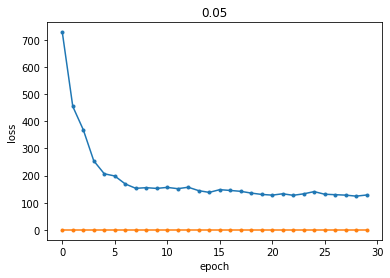

In [10]:
# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambda_ = 0.05

loss_weights = [1, lambda_]

# Adam optimizer learning rate
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)


def create_xy(slices, fixed_idx):
    ndims = len(slices.shape[1:])
    target_slice = slices[target_idx,...]
    target_data = (np.ones(slices.shape) * target_slice)[..., np.newaxis]
    moving_data = slices[..., np.newaxis]
    zero_phi = np.zeros([*slices.shape, ndims])
    x = [moving_data, target_data]
    y = [target_data, zero_phi]
    return x

# out of the training data, 29 are chosen to be for validation
train_generator = util.vxm_data_generator(slices_train_r[30:], 12, batch_size = 16)
xy_val = create_xy(slices_train_r[:29], 3)
hist = vxm_model.fit(train_generator, validation_data=xy_val, epochs=30, 
                     steps_per_epoch=slices_train_r.shape[0]//16, verbose=1)

# Visualize the losses
util.plot_history(hist, save_name = str(lambda_))
title = "w_grecrop" + str(lambda_) + ".keras"
# If it looks ok => save the weights
vxm_model.save_weights(title)



In [43]:
### RED CANAL

# Regularizer
lambda_ = 0.05
# Load the best weights found
title = "w_grecrop" + str(lambda_) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_val_gr, 3, batch_size = 5)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

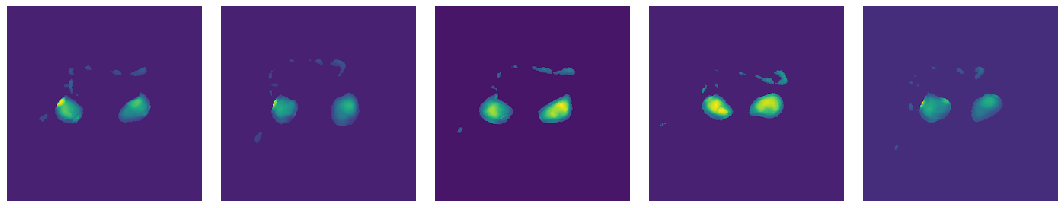

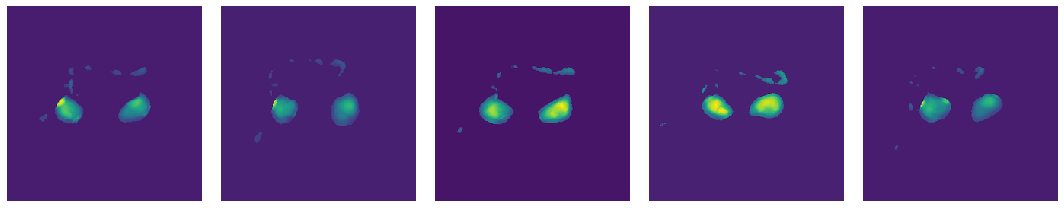

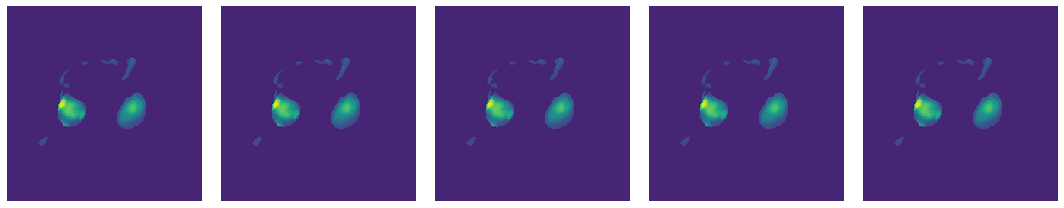

In [44]:
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]

print()
# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);